# Test the HALO Downstreaming Pipelines for regulation potential analysis

## Load the library

In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
import scanpy as sc
import anndata
import pandas as pd
import tools
import logging
import mira
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
## preprocessing the jasper files
path = "tools/motifs/"
mouse_files = pd.read_csv("tools/mouse_motif.csv")
mouse_files.head()

,x
0,MA0004.1
1,MA0006.1
2,MA0029.1
3,MA0067.1
4,MA0078.1


In [15]:
import glob
import os
import shutil

def list_files(directory):
    files_all = []
    pattern = os.path.join(directory, '**/*.jaspar')
    files = glob.glob(pattern, recursive=True)
    for file in files:
        if os.path.isfile(file):
            files_all.append(file)
    return(files_all)        


def copy_file(source_file, destination_directory):
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_directory, exist_ok=True)

    # Get the base filename from the source file path
    filename = os.path.basename(source_file)

    # Construct the destination file path
    destination_file = os.path.join(destination_directory, filename)

    # Copy the file
    shutil.copy2(source_file, destination_file)            


In [16]:
des_directory = "tools/motifs/mouse/"
mouse_files = pd.read_csv("tools/mouse_motif.csv")
motifs = list_files(path)
for file in mouse_files.x.tolist():
    for mfile in motifs:
        if file in mfile :
            copy_file(mfile, des_directory)
        else:
            pass    

In [15]:
mouse_files.head()

,x
0,MA0004.1
1,MA0006.1
2,MA0029.1
3,MA0067.1
4,MA0078.1


In [17]:
human_files = pd.read_csv("tools/human_motif.csv")
des_directory = "tools/motifs/human/"

for file in human_files.x.tolist():
    for mfile in motifs:
        if file in mfile:
            copy_file(mfile, des_directory)
        else:
            pass    

In [16]:
human_files.head()

,x
0,MA0030.1
1,MA0031.1
2,MA0051.1
3,MA0057.1
4,MA0059.1


## motif hits calculating

In [2]:
# atac_data = anndata.read_h5ad("data/datasets/A594_atac.h5ad")
atac_data = anndata.read_h5ad("data/datasets/A594_atac_interim.h5ad")
atac_data.var

,modality,feature_types,n_cells,peak,chr,start,end
gene_id,,,,,,,
1,Peaks,Peaks,389,1-9963-10665,1,9963,10665
58,Peaks,Peaks,2881,1-563942-565496,1,563942,565496
59,Peaks,Peaks,342,1-565954-566454,1,565954,566454
60,Peaks,Peaks,468,1-567637-568137,1,567637,568137
61,Peaks,Peaks,3100,1-568415-569780,1,568415,569780
...,...,...,...,...,...,...,...
189393,Peaks,Peaks,49,hs37d5-32414215-32415544,hs37d5,32414215,32415544
189399,Peaks,Peaks,57,hs37d5-32574754-32576174,hs37d5,32574754,32576174
189518,Peaks,Peaks,120,hs37d5-34974775-34975894,hs37d5,34974775,34975894


In [3]:
# atac_data = anndata.read_h5ad("data/datasets/A594_atac.h5ad")
tools.motif_scan.logger.setLevel(logging.INFO)
tools.get_motif_hits_in_peaks(atac_data,
                    genome_fasta='mm10.fa', species="human",
                    chrom = 'chr', start = 'start', end = 'end')

INFO:tools.motif_scan:Getting peak sequences ...
10313it [00:00, 199267.79it/s]
INFO:tools.motif_scan:Scanning peaks for motif hits with p >= 0.0001 ...
INFO:tools.motif_scan:Building motif background models ...
INFO:tools.motif_scan:Formatting hits matrix ...
INFO:tools.regulators:Added key to varm: motifs_hits
INFO:tools.regulators:Added key to uns: motifs


In [4]:
atac_data.write_h5ad("data/datasets/A594_atac_interim.h5ad")

## Calculating the TF enrichment

In [1]:
from typing import Dict, Iterable, Optional
import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import pandas as pd
from complementary_models import torch_infer_nonsta_dir
import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0


In [2]:
path = "/mnt/data0/halo/A594/A549_multiome.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='treatment_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

n_genes :6778
fine tune is False
gate decoder initialization n_input 10, n_output 189603,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [3]:
model = model.load("model_A594_causal02", adata_mvi)

INFO     File model_A594_causal02/model.pt already downloaded                                
n_genes :6347
fine tune is False
gate decoder initialization n_input 10, n_output 10313,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [4]:
atacloading = model.get_atac_loading()
atacloading = atacloading.T

[Text(0.5, 14.722222222222216, 'peaks')]

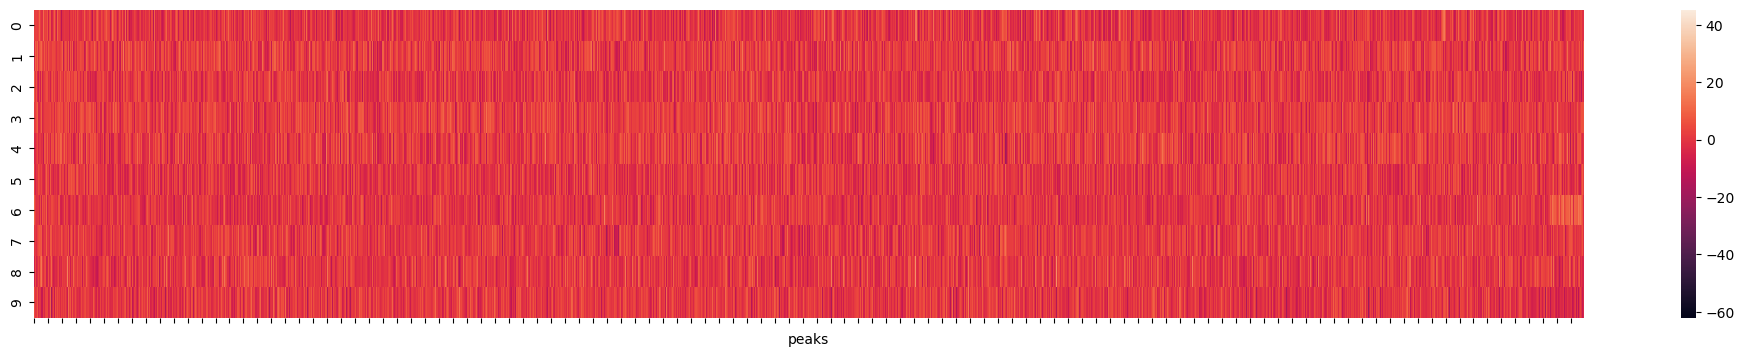

In [9]:
plt.figure(figsize=(25,4))
hm = sns.heatmap(atacloading)
hm.set(xticklabels=[]) 
hm.set(xlabel="peaks")

In [5]:
atac_data = sc.read_h5ad("data/datasets/A594_atac_interim.h5ad")
atac_data

AnnData object with n_obs × n_vars = 3260 × 10313
    obs: 'cell_name', 'experiment', 'treatment_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'latent_4', 'latent_1', 'latent_8', 'latent_0', 'latent_2', 'latent_3', 'latent_5', 'latent_6', 'latent_7', 'latent_9', 'couple', 'decouple'
    var: 'modality', 'feature_types', 'n_cells', 'peak', 'chr', 'start', 'end'
    uns: 'motifs'
    varm: 'motifs_hits'

In [9]:
rna_data = sc.read_h5ad("data/datasets/A594_rna_interim.h5ad")

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
rna_data

AnnData object with n_obs × n_vars = 3260 × 6347
    obs: 'cell_name', 'experiment', 'treatment_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'decouple', 'couple', 'decouple_4', 'decouple_5', 'decouple_1', 'decouple_8'
    var: 'gene_type', 'n_cells', 'modality', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'hvg', 'log1p'
    obsm: 'X_topic_compositions', 'X_umap'
    layers: 'counts'

In [32]:
latent_8_tf, index_learnt = model.get_enriched_TFs(atac_data, topic_num=9, top_quantile=0.5, loadings=atacloading,  num_exo_features=6000)


Finding enrichments:   0%|          | 0/107 [00:00<?, ?it/s]

In [33]:
latent_8_tf = pd.DataFrame(latent_8_tf)
latent_8_tf.sort_values(by=['pval'], ascending=True)


,id,name,parsed_name,pval,test_statistic
0,MA0483.1,GFI1B,GFI1B,1.0,NaN
77,MA0152.1,NFATC2,NFATC2,1.0,NaN
76,MA1619.1,PTF1A.VAR.2,PTF1A.VAR.2,1.0,NaN
75,MA0854.1,ALX1,ALX1,1.0,NaN
74,MA0742.1,KLF12,KLF12,1.0,NaN
...,...,...,...,...,...
30,MA0720.1,SHOX2,SHOX2,1.0,NaN
29,MA0480.1,FOXO1,FOXO1,1.0,NaN
28,MA1606.1,FOXF1,FOXF1,1.0,NaN
26,MA1604.1,EBF2,EBF2,1.0,NaN


## You  might need to compute the Mira topic models for downstreaming tasks for Now

### If you need to train the MIRA model, see the downstream_pipeline_MIRA_topics.ipynb

## Load pretrained model

In [2]:
atac_model = mira.topics.AccessibilityTopicModel(counts_layer='counts',
                                                 dataset_loader_workers = 3)

rna_model = mira.topics.ExpressionTopicModel(
    endogenous_key='endog',
    exogenous_key='endog',
    counts_layer='counts',
    seed = 0,
    hidden=64, # to make the tutorial faster. In practice, use the default of 128!
)               

In [3]:
## The original data 
rna_data = anndata.read_h5ad("data/datasets/mouse_brain_rna_interim.h5ad")
atac_data =  anndata.read_h5ad("data/datasets/mouse_brain_atac_interim.h5ad")

/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### You can also load the topic model predicted data


In [4]:
## you can also load the topic model predicted data
rna_data = anndata.read_h5ad("data/datasets/mouse_brain_rna_mira.h5ad")
atac_data =  anndata.read_h5ad("data/datasets/mouse_brain_atac_mira.h5ad")

In [5]:
rna_model = mira.topics.ExpressionTopicModel.load('MIRA/rna_topic_model.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('MIRA/atac_topic_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


## TSS Annotations

### annotate the rna data with Mouse model

In [ ]:
mira.tl.get_distance_to_TSS(atac_data,
                            tss_data='data/datasets/mm10_tss_data.bed12',
                            genome_file='data/datasets/mm10.chrom.sizes')

## Started the PR model

In [7]:
rp_args = dict(expr_adata = rna_data, atac_adata= atac_data)
rp_genes = ["ROBO1", "CTCF"]

In [8]:
litemodel = mira.rp.LITE_Model(expr_model = rna_model,
                              accessibility_model=atac_model,
                              counts_layer = 'counts',
                              genes = rp_genes)

In [9]:
## Fit the model
# litemodel.counts_layer = 'counts'
litemodel.fit(expr_adata=rna_data, atac_adata=atac_data, n_workers=4,  callback = mira.rp.SaveCallback("rpmodels/mira/"))

Fitting models: 100%|██████████| 2/2 [00:00<00:00, 17.18it/s]


In [18]:
rna_data

AnnData object with n_obs × n_vars = 3365 × 14583
    obs: 'celltype', 'batch_id', 'modality', 'latent_time', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'modality', 'n_cells'

In [11]:
atac_data.var

,chr,start,end,n_cells,types
peak_id,,,,,
1,chr1,3094399,3095523,235,coupled
2,chr1,3113503,3114077,103,neither
3,chr1,3119414,3121804,449,neither
4,chr1,3198296,3198611,46,decoupled
5,chr1,3210204,3210605,52,neither
...,...,...,...,...,...
123879,GL456216.1,37994,39286,266,neither
123880,GL456216.1,40534,41810,139,coupled
123881,GL456216.1,49045,49376,35,neither


### Pseudo-time and Lineage Analysis

In [1]:
import mira
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

umap_kwargs = dict(
    add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
    legend_fontweight=550, frameon = False, legend_fontsize=12
)

mira.datasets.PseudotimeTrajectoryInferenceTutorial()

data = anndata.read_h5ad('data/datasets/A594_rna_interim.h5ad')
mira.utils.pretty_sderr()

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/shareseq.hair_follicle.joint_representation.h5ad


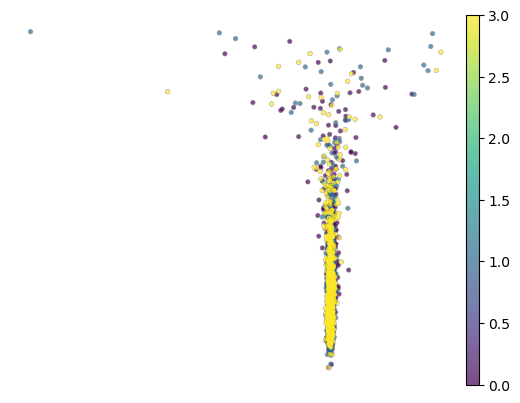

In [2]:
sc.pl.umap(data, color = 'treatment_time', palette='tab20b', legend_loc='on data', title = '', **umap_kwargs)

In [3]:
data

AnnData object with n_obs × n_vars = 3260 × 6347
    obs: 'cell_name', 'experiment', 'treatment_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'latent_4', 'latent_1', 'latent_8', 'latent_0', 'latent_2', 'latent_3', 'latent_5', 'latent_6', 'latent_7', 'latent_9', 'couple', 'decouple'
    var: 'gene_type', 'gene_name', 'n_cells', 'modality', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog', 'decouple_score', 'couple_socre'
    uns: 'hvg', 'log1p'
    obsm: 'X_topic_compositions', 'X_umap'
    layers: 'counts'

In [12]:
data.obsm.keys()

KeysView(AxisArrays with keys: X_topic_compositions, X_umap)

In [37]:
sc.pp.neighbors(data, use_rep = 'X_topic_compositions', metric = 'manhattan',
               n_neighbors = 20)

In [38]:
sc.tl.diffmap(data)
mira.time.normalize_diffmap(data)

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 11 diffusion map components.


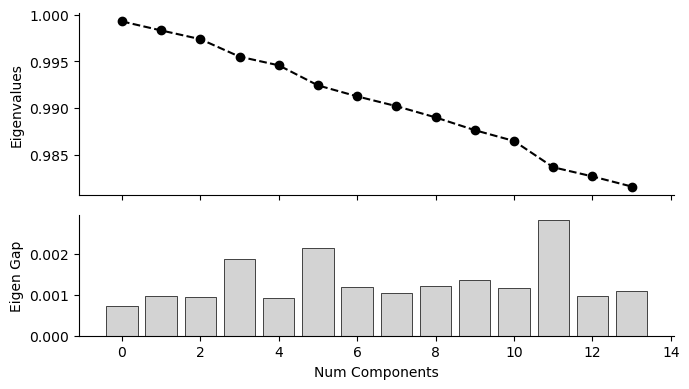

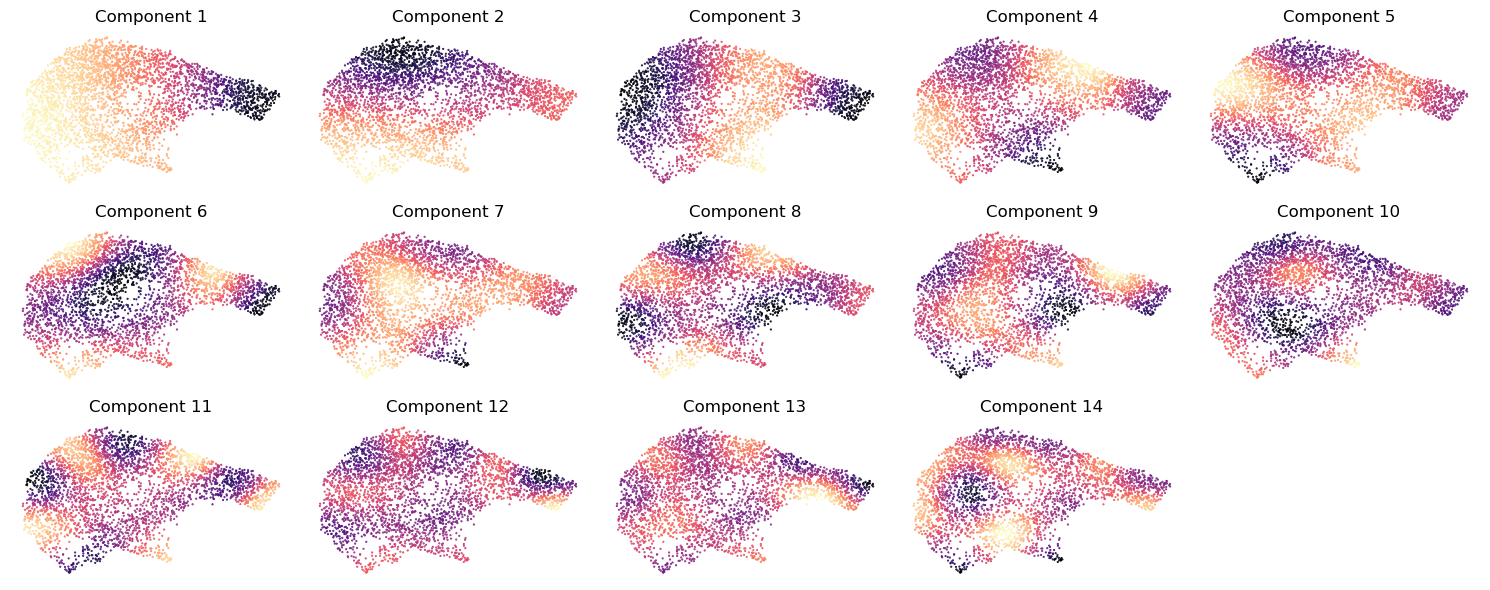

In [39]:
mira.pl.plot_eigengap(data, palette='magma')
plt.show()

In [40]:
data.obsm['X_diffmap'] = data.obsm['X_diffmap'][:,:5] # subset the number of dimensions
sc.pp.neighbors(data, use_rep='X_diffmap', key_added='X_diffmap')

In [41]:
mira.time.get_connected_components(data)


INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components


In [42]:
mira.time.get_transport_map(data, start_cell= int(data.obs['treatment_time'].argmin()))


INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
INFO:root:Using 1 core. Speed this up by allocating more n_jobs.
Calculating pseudotime: 2063it [00:00, 659616.49it/s]                          
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


... storing 'gene_name' as categorical


<AxesSubplot:title={'center':'treatment_time'}, xlabel='UMAP1', ylabel='UMAP2'>

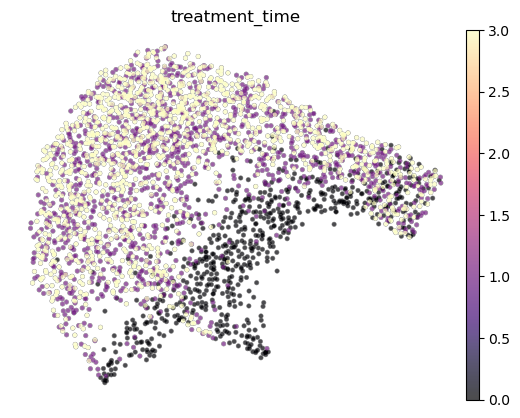

In [58]:
sc.pl.umap(data, color = 'treatment_time', show = False,
           **umap_kwargs, color_map = 'magma')

INFO:mira.pseudotime.pseudotime:Found 1 terminal states from stationary distribution.


Terminal cells:  sci-RNA-C-008.GATTCCGGAA_paired


INFO:mira.pseudotime.pseudotime:Found 4 terminal states from stationary distribution.


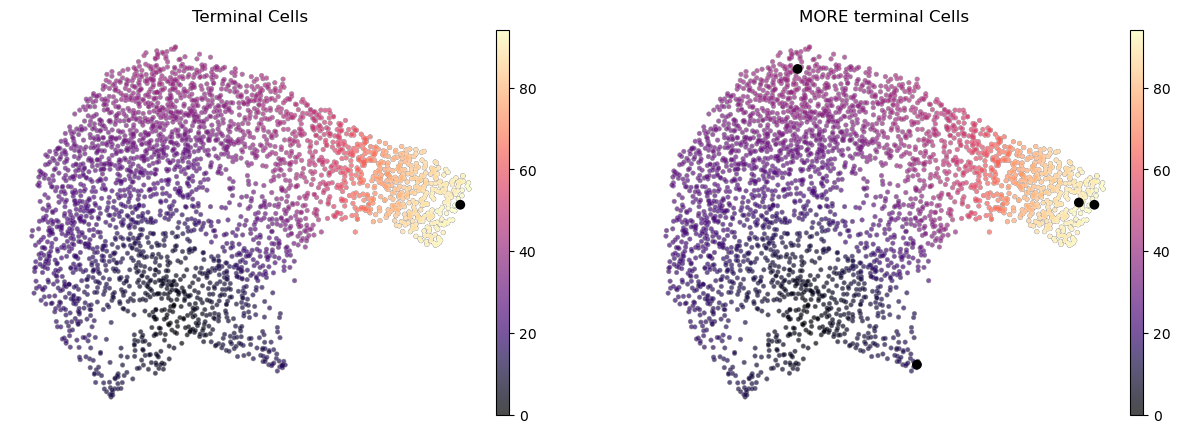

In [44]:
terminal_cells = mira.time.find_terminal_cells(data, seed = 3)
print('Terminal cells: ', ', '.join(terminal_cells))
MORE_terminal_cells = mira.time.find_terminal_cells(data, seed = 3, iterations = 10, threshold=1e-2)


In [88]:
terminal_cells =[data.obs[data.obs.treatment_time==0].index[5], data.obs[data.obs.treatment_time==1].index[5], data.obs[data.obs.treatment_time==3].index[2]]
terminal_cells

['sci-RNA-A-089.GACCAATGCG_paired',
 'sci-RNA-A-023.AGCGATCCGC_paired',
 'sci-RNA-A-071.GGCTCGAGAT_paired']

... storing 'gene_name' as categorical


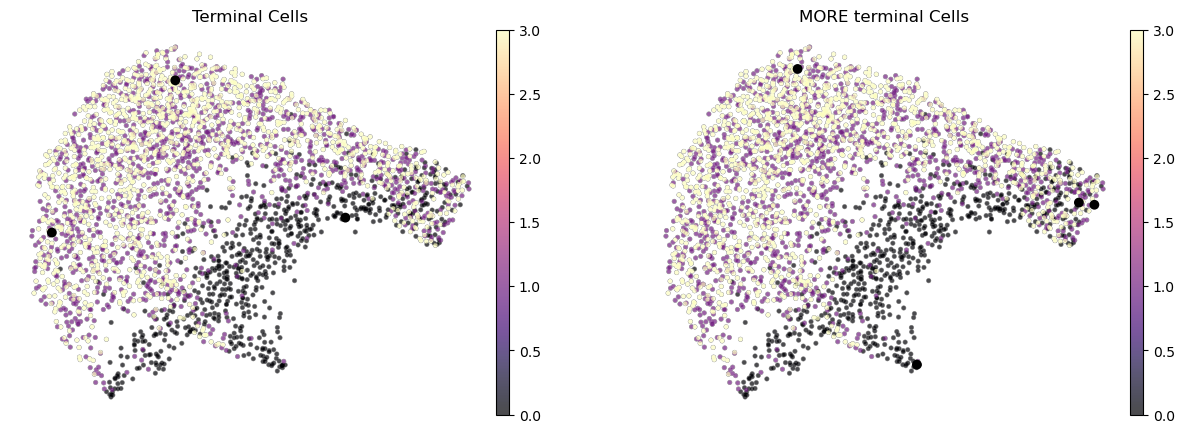

In [89]:

fig, ax = plt.subplots(1,2,figsize=(15,5))
sc.pl.umap(data, color = 'treatment_time', show = False,
           **umap_kwargs, color_map = 'magma', ax = ax[0])
sc.pl.umap(data[terminal_cells], na_color = 'black', ax = ax[0],
          size = 200, title = 'Terminal Cells', show=False)

sc.pl.umap(data, color = 'treatment_time', show = False,
           **umap_kwargs, color_map = 'magma', ax = ax[1])
sc.pl.umap(data[MORE_terminal_cells], na_color = 'black', ax = ax[1],
           size = 200, title = 'MORE terminal Cells')

In [90]:
mira.time.get_branch_probabilities(data, terminal_cells= {
    'hours_0' : terminal_cells[0],
    'hours_1' : terminal_cells[1],
    'hours_3' : terminal_cells[2]
})

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: hours_0_prob
INFO:mira.adata_interface.core:Added cols to obs: hours_1_prob
INFO:mira.adata_interface.core:Added cols to obs: hours_3_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


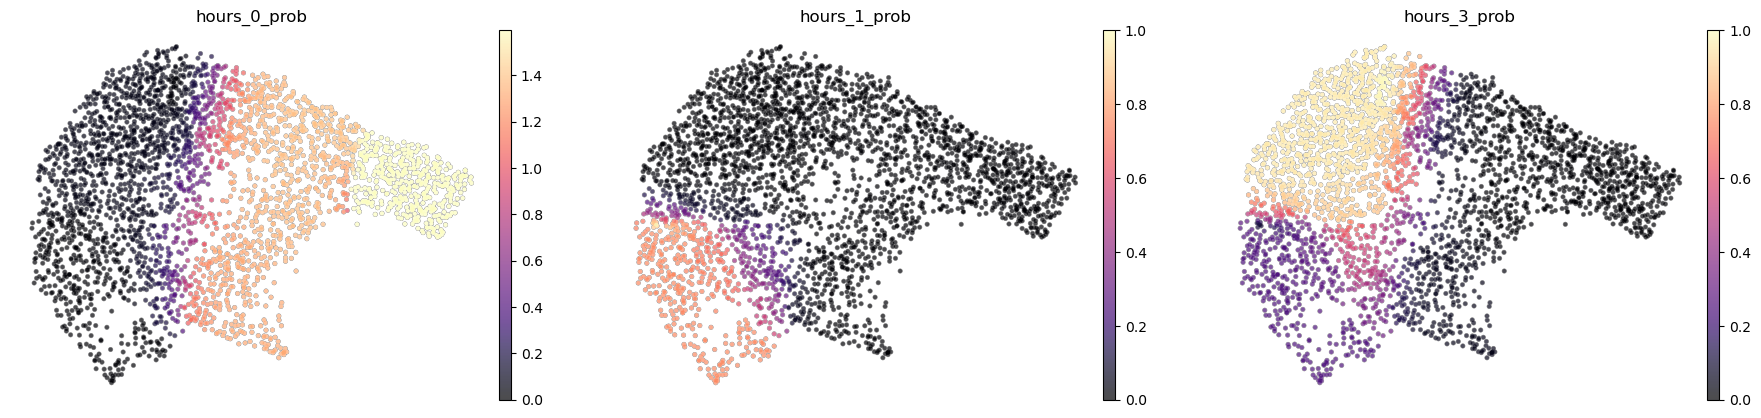

In [94]:
sc.pl.umap(data,
   color = [x + '_prob' for x in data.uns['lineage_names']],
   color_map='magma', **umap_kwargs)

INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree
... storing 'tree_states' as categorical
... storing 'gene_name' as categorical


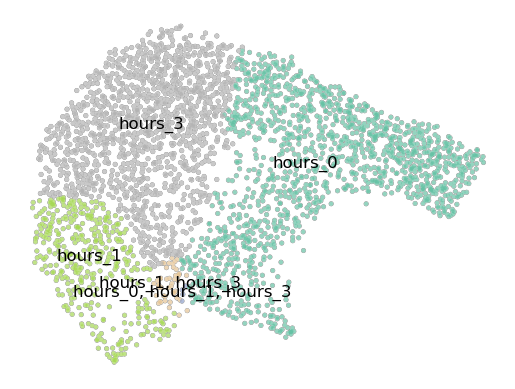

In [92]:
mira.time.get_tree_structure(data, threshold = 0.58)
sc.pl.umap(data, color = 'tree_states', palette = 'Set2',
           **umap_kwargs, title = '', legend_loc='on data')

In [95]:
data.var.gene_name = data.var.gene_name.astype(str)

data.var_names = data.var.gene_name

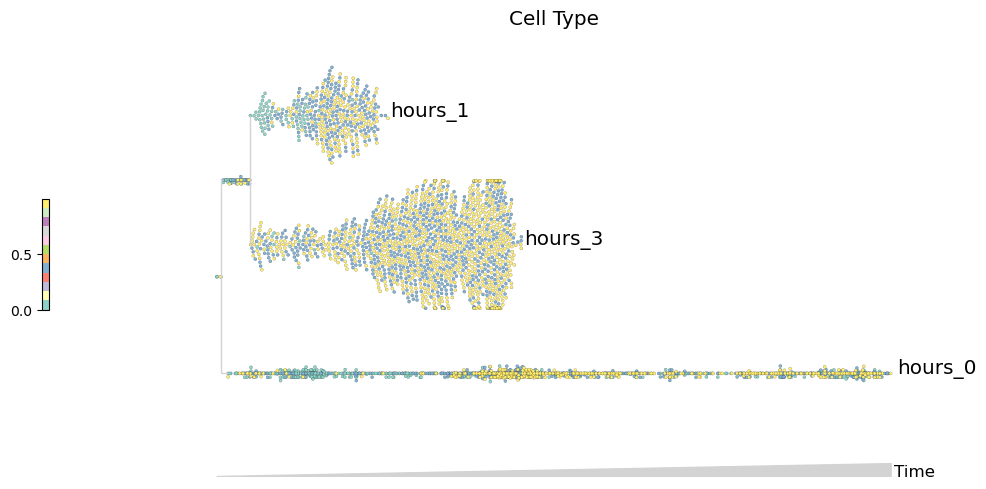

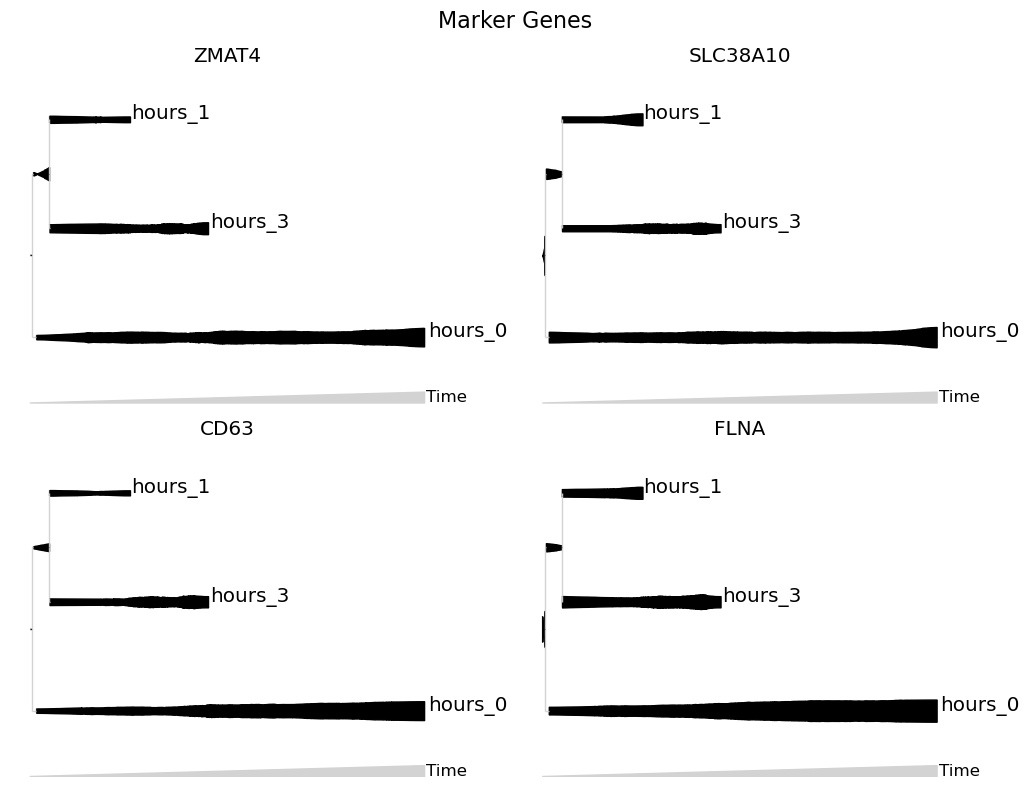

In [96]:
data.obs.true_cell = data.obs.treatment_time.astype(str)
data.var.gene_name = data.var.gene_name.astype(str)
mira.pl.plot_stream(data, data = 'treatment_time', log_pseudotime=False, max_bar_height=0.99, title = 'Cell Type',
                    figsize=(10,5), style = 'swarm', palette='Set3', size = 5, max_swarm_density = 100)


mira.pl.plot_stream(data, data = ['ZMAT4','SLC38A10','CD63','FLNA'],
    log_pseudotime=False, layers = None, plots_per_row = 2,
    clip = 3, window_size=301, scale_features=True, split = True,
    title = 'Marker Genes')
plt.show()

In [30]:
data.obs.columns

Index(['cell_name', 'experiment', 'treatment_time', 'batch_id', 'modality',
       '_scvi_batch', '_scvi_labels', 'latent_4', 'latent_1', 'latent_8',
       'latent_0', 'latent_2', 'latent_3', 'latent_5', 'latent_6', 'latent_7',
       'latent_9', 'couple', 'decouple', 'mira_connected_components',
       'mira_pseudotime', 'three_hours_1_prob', 'Three_hours_2_prob',
       'Three_hours_3_prob', 'differentiation_entropy', 'tree_states'],
      dtype='object')

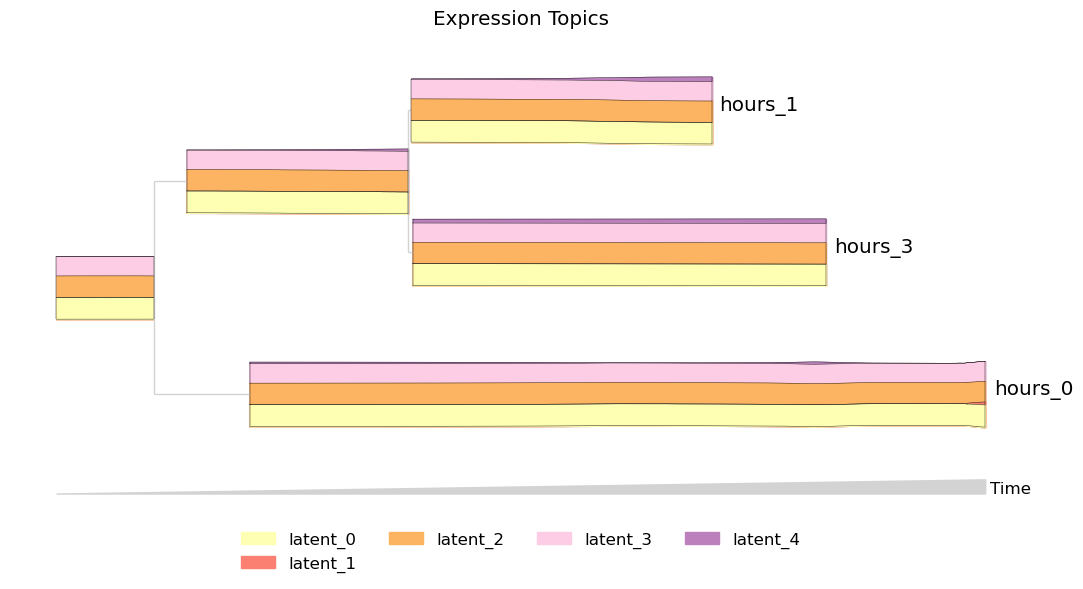

In [98]:
plot_kwargs = dict(hide_feature_threshold=0.03, linewidth=0.3, max_bar_height=0.8,
                    window_size=301, legend_cols=4, figsize = (11,6))

mira.pl.plot_stream(data,
                    data = ['latent_' + str(i) for i in range(5)],
                    title = 'Expression Topics',
                    palette=sns.color_palette('Set3')[1::2], # warm tones
                    **plot_kwargs)

plt.show()